# Neural Networks

For a description of the neural networks, please see the notebook titled 'Description neural networks'. The neural network implementation that we will use here can be seen in 'neural_networks'. Before using my implementation of neural networks (based on Andrew Ng's lecture notes on neural networks, https://class.coursera.org/ml-003/lecture, accessed in June 2016) classifier, we can take a look at whether the algorithm is working correctly. First fit a neural network with a reduced number of iterations and allow derivative checking. Then plot the error term, which should decrease with successive iterations. The derivatives calculated analytically and numerically should be very close to each other. 

In [73]:
classifier_nn = neural_networks.neural_network(number_of_hidden_layers = 2,learning_rate = 0.7,initial_weight_limit = 0.7,tuning_parameter = 0,iterations = 50)
classifier_nn.fit(X_train_validation,y_train_validation,derivative_check = True)

In [74]:
print(classifier_nn.derivative_compare.head(10))

   analytic  numerical
0  0.317589   0.317589
1  0.057058   0.057058
2  0.021691   0.021691
3  0.011164   0.011164
4  0.007354   0.007354
5  0.005849   0.005849
6  0.005201   0.005201
7  0.004883   0.004883
8  0.004694   0.004694
9  0.004558   0.004558


(0, 51)

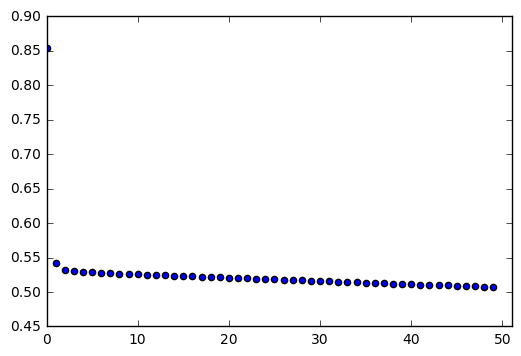

In [75]:
#Plot the error
plt.figure()
plt.scatter(xrange(len(classifier_nn.get_error_list())),classifier_nn.get_error_list())
plt.xlim(0,len(classifier_nn.get_error_list()) + 1)

The graph shows that the algorithm reduces the error with each iteration. The error term drops sharply after the first iteration, followed by a gradual but continuous decline. The 'analytic' and 'numerical' derivative calculations are the same, indicating that the derivative is being calculated correctly. The neural network notebook in the Machine Learning directory includes the code that generates the numerical derivative and the calculation of the derivative analytically. When we run the neural network algorithm, we will use more iterations to better fit the data and turn off the numerical derivative calculation, because it increases the calculation time.

In [76]:
classifier_nn = neural_networks.neural_network(initial_weight_limit = 0.7,tuning_parameter = 0,iterations = 500)
#We can now test different numbers of layers and learning rates for the neural network. 
#We will set the number of iterations to 500 to find the optimal hyper-parameter values.
hyper_parameters_nn = [{'number_of_hidden_layers':[1,2,3],'learning_rate':[0.3,0.7],'tuning_parameter': [0,0.1]}]

In [77]:
grid = GridSearchCV(classifier_nn,hyper_parameters_nn,cv = 3, scoring = score_cost,refit = True)
grid.fit(X_train_validation,y_train_validation)

max_score = 0
#Print the scores from the iterations and the parameter
#values that give the best result
for params, mean_score, scores in grid.grid_scores_:
    print('%0.3f (+/-%0.03f) for %r' % (mean_score, scores.std() * 2, params))
    if mean_score > max_score:
        max_score = mean_score
print(grid.best_params_,'max score',max_score)

-2628.542 (+/-121.285) for {'learning_rate': 0.3, 'number_of_hidden_layers': 1, 'tuning_parameter': 0}
-2617.083 (+/-121.837) for {'learning_rate': 0.3, 'number_of_hidden_layers': 1, 'tuning_parameter': 0.1}
-2745.625 (+/-135.030) for {'learning_rate': 0.3, 'number_of_hidden_layers': 2, 'tuning_parameter': 0}
-2702.917 (+/-123.780) for {'learning_rate': 0.3, 'number_of_hidden_layers': 2, 'tuning_parameter': 0.1}
-3311.875 (+/-1.230) for {'learning_rate': 0.3, 'number_of_hidden_layers': 3, 'tuning_parameter': 0}
-3311.875 (+/-1.230) for {'learning_rate': 0.3, 'number_of_hidden_layers': 3, 'tuning_parameter': 0.1}
-2463.333 (+/-136.910) for {'learning_rate': 0.7, 'number_of_hidden_layers': 1, 'tuning_parameter': 0}
-2465.417 (+/-138.525) for {'learning_rate': 0.7, 'number_of_hidden_layers': 1, 'tuning_parameter': 0.1}
-2415.625 (+/-95.995) for {'learning_rate': 0.7, 'number_of_hidden_layers': 2, 'tuning_parameter': 0}
-2400.833 (+/-114.981) for {'learning_rate': 0.7, 'number_of_hidden_la

The initial analysis suggests that 2 hidden layers, a learning rate of 0.7 and tuning parameter value of 0.1 is appropriate. We can repeat the fit with more iterations.

In [78]:
classifier_nn = neural_networks.neural_network(number_of_hidden_layers = 2, learning_rate = 0.7, initial_weight_limit = 0.7,tuning_parameter = 0.1,iterations = 6000)
classifier_nn.fit(X_train_validation,y_train_validation,derivative_check = False)

In [79]:
#Use the model on the test set and get uncalibrated probabilities
probabilities_test = classifier_nn.predict_proba(X_test)
#Get training probabilities for probability calibration
probabilities_train = classifier_nn.predict_proba(X_train_validation)
#Calibrate probabilities with isotonic regression
ir.fit(probabilities_train,y_train_validation)                          
#Calibrate probabilities with platt's method
lr.fit(probabilities_train.reshape( -1, 1 ),y_train_validation) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

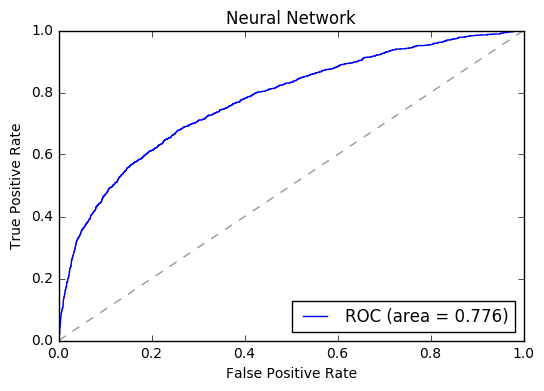

In [80]:
#Use the model on the test set and get uncalibrated probabilities
mean_fpr = np.linspace(0, 1, 100)
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)
roc_auc = auc(fpr, tpr)
plt.figure(14)    
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)' % (roc_auc))
plt.title('Neural Network')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

In [81]:
#Use the cost sensitive threshold to predict the outcome
predictions_test_cost = [0 if x < threshold_cost else 1 for x in probabilities_test]
#Use the 50% threshold to predict the outcome
predictions_test_50 = [0 if x < threshold_05 else 1 for x in probabilities_test]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_isotonic = ir.transform(probabilities_test)
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_isotonic_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_isotonic]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_isotonic_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_isotonic]
#Calibrate the probabilities by isotonic regression 
probas_calibrated_platt = lr.predict_proba(probabilities_test.reshape( -1, 1 ))[:,1]
#Use the cost sensitive threshold to predict the outcome
predictions_test_calibrated_platts_cost = [0 if x < threshold_cost else 1 for x in probas_calibrated_platt]
#Use the 50% threshold to predict the outcome
predictions_test_calibrated_platts_50 = [0 if x < threshold_05 else 1 for x in probas_calibrated_platt]

In [82]:
#Print the expected cost and the classification report for uncalibrated probabilities, 
#isotonic calibrated probabilities and platts calibrated probabilities
#with cost-sensitive threshold and 50% threshold
print('Uncalibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_cost))
print(classification_report(y_test, predictions_test_cost,target_names = ['Pay','Default']))
print('Uncalibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_50))
print(classification_report(y_test, predictions_test_50,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_cost))
print(classification_report(y_test, predictions_test_calibrated_isotonic_cost,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_isotonic_50))
print(classification_report(y_test, predictions_test_calibrated_isotonic_50,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_cost))
print(classification_report(y_test, predictions_test_calibrated_platts_cost,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, predictions_test_calibrated_platts_50))
print(classification_report(y_test, predictions_test_calibrated_platts_50,target_names = ['Pay','Default']))
print('Dummy classifier: %i ' % expected_cost(y_test, clf_predictions))
print(classification_report(y_test, clf_predictions,target_names = ['Pay','Default']))

Uncalibrated probabilities, cost sensitive threshold: 2057 
             precision    recall  f1-score   support

        Pay       0.87      0.84      0.86      4663
    Default       0.51      0.57      0.54      1337

avg / total       0.79      0.78      0.79      6000

Uncalibrated probabilities, 50pct threshold: 2345 
             precision    recall  f1-score   support

        Pay       0.84      0.95      0.89      4663
    Default       0.67      0.36      0.47      1337

avg / total       0.80      0.82      0.80      6000

Isotonic calibrated probabilities, cost sensitive threshold: 2067 
             precision    recall  f1-score   support

        Pay       0.88      0.81      0.84      4663
    Default       0.48      0.60      0.53      1337

avg / total       0.79      0.77      0.77      6000

Isotonic calibrated probabilities, 50pct threshold: 2351 
             precision    recall  f1-score   support

        Pay       0.84      0.95      0.89      4663
    Default 

Neural networks provided the best fit among the other classifiers. It has the lowest cost outcome and a slightly higher area under the curve value.